## Stimuli Project PSD

In [30]:
import os
import mne
import numpy as np
from typing import Dict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


from NirsLabProject.config.paths import Paths
from NirsLabProject.config.consts import *
from NirsLabProject.config.subject import Subject
from NirsLabProject.utils import pipeline_utils
from NirsLabProject.utils import general_utils as utils



In [3]:
subject = Subject('p485', True)
raw = pipeline_utils.resample_and_filter_data(subject)

Reading raw data...
Data for electrode LMH was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['LMH1', 'LMH2', 'LMH3', 'LMH4', 'LMH5', 'LMH6', 'LMH7'] channels, 1000.0 Hz
Data for electrode LOF was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['LOF1', 'LOF2', 'LOF3', 'LOF4', 'LOF5', 'LOF6', 'LOF7'] channels, 1000.0 Hz
Data for electrode RBAA was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['RBAA1', 'RBAA2', 'RBAA3', 'RBAA4', 'RBAA5', 'RBAA6', 'RBAA7'] channels, 1000.0 Hz
Data for electrode ROF was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['ROF1', 'ROF2', 'ROF3', 'ROF4', 'ROF5', 'ROF6', 'ROF7'] channels, 1000.0 Hz
Data for electrode RPHG was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['RPHG1', 'RPHG2', 'RPHG3', 'RPHG4', 'RPHG5', 'RPHG6', 'RPHG7'] chan

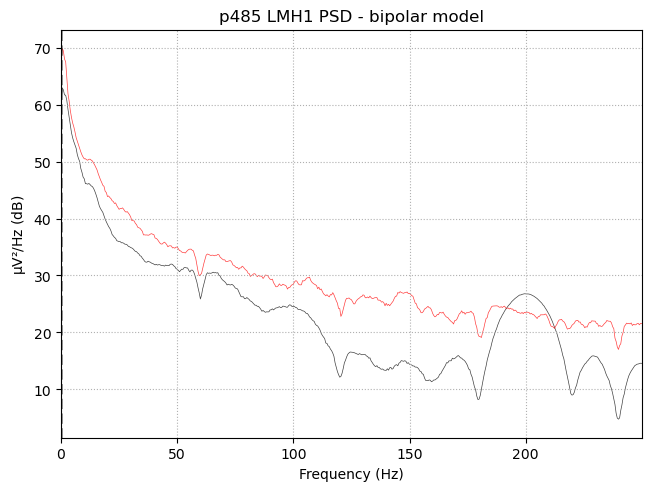

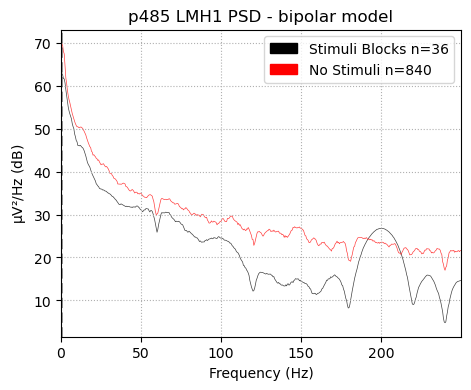

In [47]:
def get_model_name(subject: Subject) -> str:
    return f"{'bipolar' if subject.bipolar_model else 'one channel'} model"

def create_psd_of_stimuli_and_pause_blocks(
        subject: Subject, flat_features: np.ndarray, raw: mne.io.Raw, channel_name: str,
        name_to_index: Dict[str, int], show: bool = False):
        channel_index = name_to_index.get(channel_name, None)
        if channel_index is None:
            print(f'Channel {channel_name} not found')
            return
        
        only_stimuli_block_indexes = np.logical_and(
            flat_features[:, CHANNEL_INDEX] == channel_index,
            flat_features[:, STIMULI_FLAG_INDEX] == STIMULI_FLAG_DURING_STIMULI_BLOCK
        )
        
        without_stimuli_blocks_indexes = np.logical_and(
            flat_features[:, CHANNEL_INDEX] == channel_index,
            flat_features[:, STIMULI_FLAG_INDEX] != STIMULI_FLAG_DURING_STIMULI_BLOCK,
        )
                
        channel_raw = raw.copy().pick_channels([channel_name])
        channel_raw.load_data()
        only_stimuli_block_times = flat_features[only_stimuli_block_indexes][:, TIMESTAMP_INDEX]
        only_stimuli_block_times = only_stimuli_block_times.reshape(-1, 1).astype(int)
        stimuli_epochs = utils.create_epochs(channel_raw, only_stimuli_block_times, -1, 1)
        
        without_stimuli_blocks_times = flat_features[without_stimuli_blocks_indexes][:, TIMESTAMP_INDEX]
        without_stimuli_blocks_times = without_stimuli_blocks_times.reshape(-1, 1).astype(int)
        no_stimuli_epochs = utils.create_epochs(channel_raw, without_stimuli_blocks_times, -1, 1)
        
        fig = plt.figure(layout='constrained')
        ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
        # plot_psd is obsolete, but the new function plot_psd_topomap is not supporting fig saving
        stimuli_epochs.plot_psd(
            fmin=0,
            fmax=250,
            picks=[channel_name],
            ax=ax,
            show=show,
            spatial_colors=False
        )

        no_stimuli_epochs.plot_psd(
            fmin=0,
            fmax=250,
            ax=ax,
            show=show,
            spatial_colors=False,
            color='red'
        )
        ax.set_title(f'{subject.name} {channel_name} PSD - {get_model_name(subject)}')
        ax.set_xlabel('Frequency (Hz)')
        legend = [
            mpatches.Patch(color='black', label=f'Stimuli Blocks n={only_stimuli_block_times.shape[0]}'),
            mpatches.Patch(color='red', label=f'No Stimuli n={without_stimuli_blocks_times.shape[0]}')
        ]
        ax.legend(handles=legend, bbox_to_anchor=(1, 1))
        plt.tight_layout()
        plt.savefig(os.path.join(subject.paths.subject_psd_plots_dir_path, f'{subject.name}-{channel_name}-stimuli-blocks-vs-non.png'),  dpi=1000)
        if show:
            plt.show()
        
features = np.load(subject.paths.subject_flat_features_path, allow_pickle=True)
index_to_name = np.load(subject.paths.subject_channel_name_to_index_path, allow_pickle=True).item()
name_to_index = {name: index for index, name in index_to_name.items()}

create_psd_of_stimuli_and_pause_blocks(subject, features, raw['LMH'], 'LMH1', name_to_index, True)